In [1]:
# import libraries
#try:
  # %tensorflow_version only exists in Colab.
  #!pip install tf-nightly
#except Exception:
#  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
#!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall, Precision

print(tf.__version__)

2.9.2


# Load and prepare data

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2022-10-25 14:08:03--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.004s  

2022-10-25 14:08:03 (81.4 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2022-10-25 14:08:03--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [3]:
# load data
df_train = pd.read_csv(train_file_path, sep='\t', header=None, names=['category', 'text'])
df_test = pd.read_csv(test_file_path, sep='\t', header=None, names=['category', 'text'])
df_test.tail()

,category,text
1387,ham,true dear..i sat to pray evening and felt so.s...
1388,ham,"what will we do in the shower, baby?"
1389,ham,where are you ? what are you doing ? are yuou ...
1390,spam,ur cash-balance is currently 500 pounds - to m...
1391,spam,not heard from u4 a while. call 4 rude chat pr...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


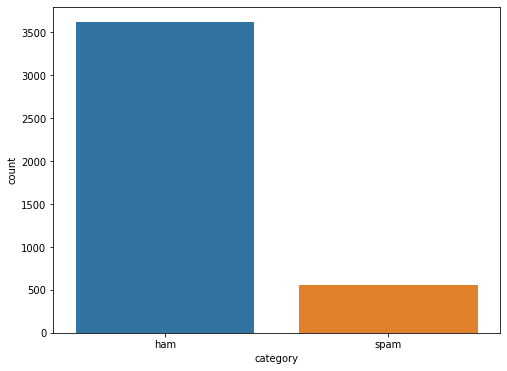

In [4]:
# plot ham-spam count in training dataset
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(df_train['category'], ax=ax)

In [5]:
# balancing ham-spam ratio in training dataset
spam_set = df_train.loc[df_train['category'] == 'spam']
ham_set = df_train.loc[df_train['category'] == 'ham']
ham_set = ham_set.sample(len(spam_set), random_state=0)
df_train = ham_set.append(spam_set)
df_train

,category,text
262,ham,they just talking thats it de. they wont any o...
2635,ham,the 2 oz guy is being kinda flaky but one frie...
3813,ham,at 4. let's go to bill millers
2483,ham,"hiya, probably coming home * weekend after next"
2919,ham,just finished. missing you plenty
...,...,...
4164,spam,free msg: single? find a partner in your area!...
4165,spam,free2day sexy st george's day pic of jordan!tx...
4167,spam,you are a winner you have been specially selec...
4176,spam,free entry into our £250 weekly competition ju...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


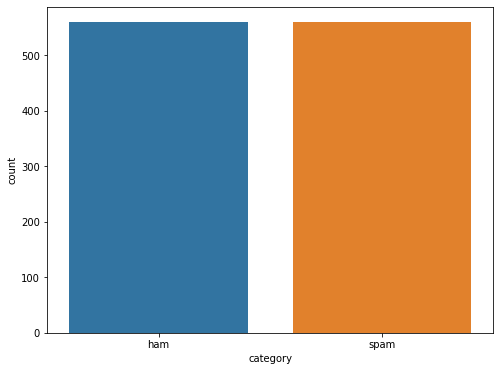

In [6]:
# plot balanced occurencies dataset
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(df_train['category'], ax=ax)

In [7]:
# split text and labels
df_train['label'] = df_train['category'].map({'ham':0,'spam':1})
df_test['label'] = df_test['category'].map({'ham':0,'spam':1})
x_train = df_train['text'].values
y_train = df_train['label'].values
x_test = df_test['text'].values
y_test = df_test['label'].values

In [8]:
# vectorize texts in datasets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(x_train) + list(x_test))
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# peek first text in train set
x_train[0]

[119, 31, 1947, 339, 21, 762, 119, 474, 93, 279]

In [9]:
# just set max sequence length to 100 and use right padding
x_train = pad_sequences(np.array(x_train), maxlen=100)
x_test = pad_sequences(np.array(x_test), maxlen=100)
y_train = np.array(y_train)
y_test = np.array(y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# check shape of first text (should have length of 100)
x_train[0].shape

(100,)

# Create and train model

In [11]:
# create and train model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index)+1, 100, input_length=100),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    #LSTM(8, recurrent_dropout=0.2), # LSTM does not pass one o fthe 5 test cases most of the time, although it still seems to work in general
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          618400    
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 620,033
Trainable params: 620,033
Non-trainable params: 0
__________________________________________________

In [12]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_train, y_train, epochs=200, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/200
35/35 [==============================] - 4s 19ms/step - loss: 0.6910 - accuracy: 0.5045 - val_loss: 0.6717 - val_accuracy: 0.8657
Epoch 2/200
35/35 [==============================] - 0s 10ms/step - loss: 0.6817 - accuracy: 0.5536 - val_loss: 0.6444 - val_accuracy: 0.8664
Epoch 3/200
35/35 [==============================] - 0s 11ms/step - loss: 0.6560 - accuracy: 0.6438 - val_loss: 0.5793 - val_accuracy: 0.9274
Epoch 4/200
35/35 [==============================] - 1s 15ms/step - loss: 0.5927 - accuracy: 0.8339 - val_loss: 0.4915 - val_accuracy: 0.9684
Epoch 5/200
35/35 [==============================] - 0s 10ms/step - loss: 0.4862 - accuracy: 0.8946 - val_loss: 0.3995 - val_accuracy: 0.9734
Epoch 6/200
35/35 [==============================] - 0s 11ms/step - loss: 0.3628 - accuracy: 0.9393 - val_loss: 0.2506 - val_accuracy: 0.9756
Epoch 7/200
35/35 [==============================] - 0s 11ms/step - loss: 0.2567 - accuracy: 0.9518 - val_loss: 0.1998 - val_accuracy: 0.9749
Epoch 

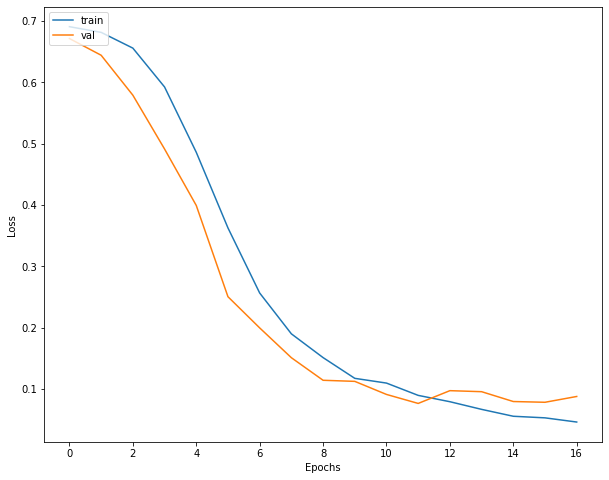

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
ax.legend(['train', 'val'], loc='upper left')

# Create and test classifier

In [14]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  # tokenize and pad input
  text = pad_sequences(tokenizer.texts_to_sequences([pred_text]), maxlen=100)
  # make prediction using the trained model
  prediction = model.predict(text)[0, 0]
  # return prediction and label
  return [prediction, 'spam' if round(prediction) else 'ham']

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 69ms/step
[0.025552478, 'ham']


In [15]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    print(prediction)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 14ms/step
[0.025552478, 'ham']
1/1 [==============================] - 0s 15ms/step
[0.6174515, 'spam']
1/1 [==============================] - 0s 14ms/step
[0.015269228, 'ham']
1/1 [==============================] - 0s 15ms/step
[0.9764153, 'spam']
1/1 [==============================] - 0s 13ms/step
[0.98193526, 'spam']
1/1 [==============================] - 0s 13ms/step
[0.0068084504, 'ham']
1/1 [==============================] - 0s 13ms/step
[0.04836502, 'ham']
You passed the challenge. Great job!
